In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import joblib
import random


In [9]:
# Load the steel industry dataset
data = pd.read_csv('Steel_industry_data.csv')  # Ensure correct path to your file

# Display the first few rows, data info, and summary statistics
print("First few rows of the dataset:")
print(data.head())
print("\nDataset Info:")
print(data.info())
print("\nDataset Statistics:")
print(data.describe())


First few rows of the dataset:
               date  Usage_kWh  Lagging_Current_Reactive.Power_kVarh  \
0  01/01/2018 00:15       3.17                                  2.95   
1  01/01/2018 00:30       4.00                                  4.46   
2  01/01/2018 00:45       3.24                                  3.28   
3  01/01/2018 01:00       3.31                                  3.56   
4  01/01/2018 01:15       3.82                                  4.50   

   Leading_Current_Reactive_Power_kVarh  CO2(tCO2)  \
0                                   0.0        0.0   
1                                   0.0        0.0   
2                                   0.0        0.0   
3                                   0.0        0.0   
4                                   0.0        0.0   

   Lagging_Current_Power_Factor  Leading_Current_Power_Factor   NSM  \
0                         73.21                         100.0   900   
1                         66.77                         100.0  1800  

In [10]:
# Check for missing values and duplicate rows
print("Missing values in each column:")
print(data.isnull().sum())
print("Number of duplicate rows:", data.duplicated().sum())


Missing values in each column:
date                                    0
Usage_kWh                               0
Lagging_Current_Reactive.Power_kVarh    0
Leading_Current_Reactive_Power_kVarh    0
CO2(tCO2)                               0
Lagging_Current_Power_Factor            0
Leading_Current_Power_Factor            0
NSM                                     0
WeekStatus                              0
Day_of_week                             0
Load_Type                               0
dtype: int64
Number of duplicate rows: 0


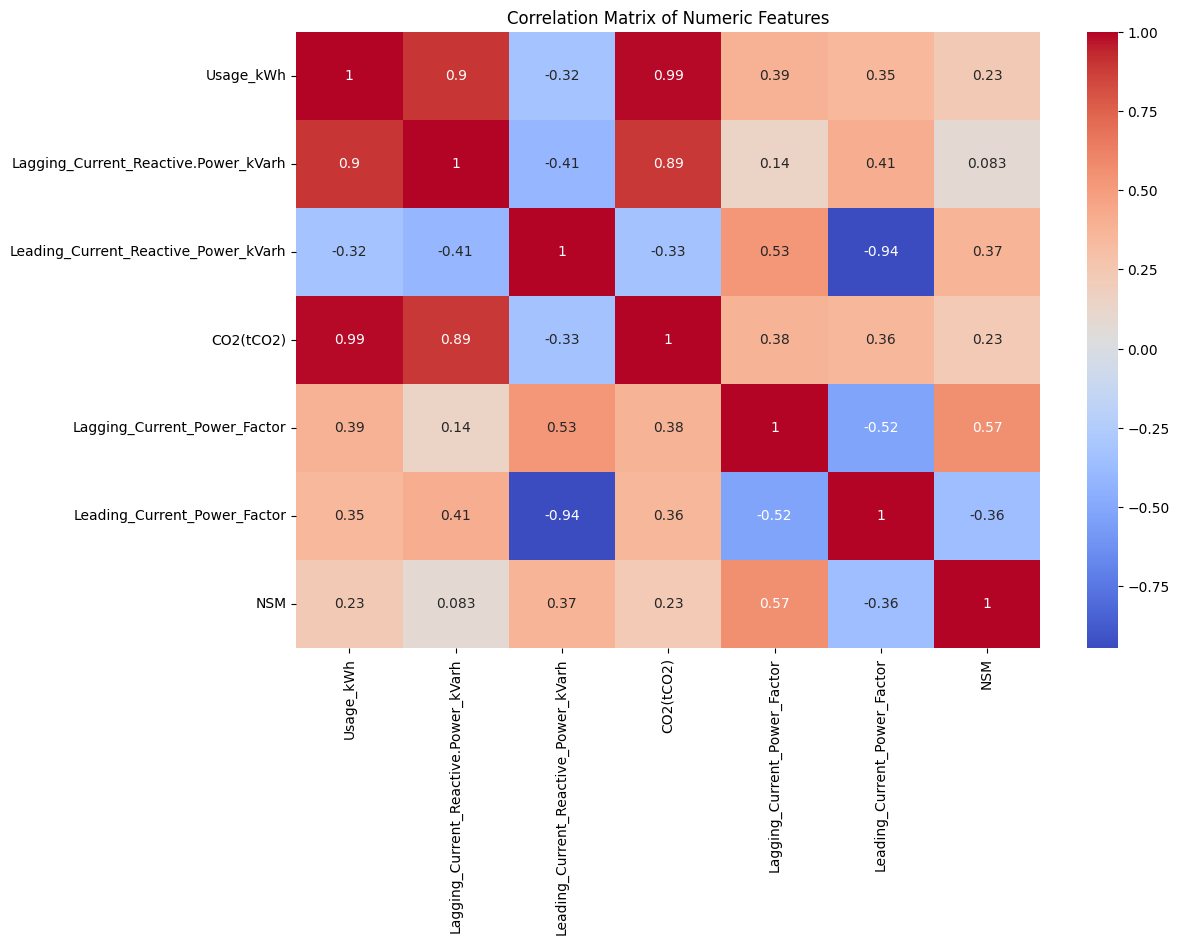

In [11]:
# Visualize the correlation matrix for numeric columns
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [12]:
# Fill missing numeric values with median
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Standardize numeric features
scaler = StandardScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Encode categorical variables
encoder = LabelEncoder()
for col in data.select_dtypes(include='object').columns:
    data[col] = encoder.fit_transform(data[col])


In [13]:
# Apply PCA to reduce dimensions, keeping 5 principal components
pca = PCA(n_components=5)
principal_components = pca.fit_transform(data.select_dtypes(include=[np.number]))
data_pca = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 6)])

# Display the PCA-transformed data
data_pca.head()


,PC1,PC2,PC3,PC4,PC5
0,-17518.500002,-2.156821,-0.524527,-1.809508,-0.552559
1,-17517.500003,-2.148278,-0.509248,-1.966617,-0.491665
2,-17516.500003,-2.156307,-0.526804,-1.856694,-0.480730
3,-17515.500003,-2.155892,-0.529085,-1.899862,-0.439367
4,-17514.500004,-2.149478,-0.513917,-1.974446,-0.399246


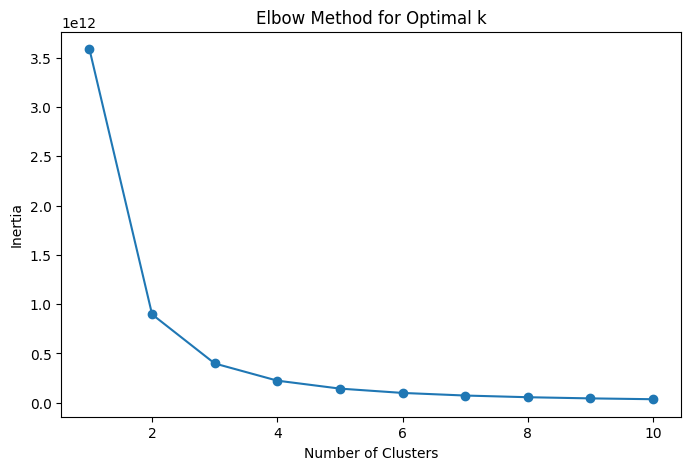

In [14]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-Means with an optimal number of clusters (e.g., k=4)
optimal_k = 4  # Update based on elbow plot results
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
data['Cluster'] = kmeans.fit_predict(data_pca)


In [15]:
# Define features and target for classification (using Cluster as target example)
X_classification = data.drop(["Cluster"], axis=1)
y_classification = data["Cluster"]

# Split the data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train_class, y_train_class)

# Model evaluation
y_pred_class = classifier.predict(X_test_class)
print("Classification Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Classification Report:\n", classification_report(y_test_class, y_pred_class))
print("Confusion Matrix:\n", confusion_matrix(y_test_class, y_pred_class))


Classification Accuracy: 0.9997146118721462
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1711
           1       1.00      1.00      1.00      1791
           2       1.00      1.00      1.00      1763
           3       1.00      1.00      1.00      1743

    accuracy                           1.00      7008
   macro avg       1.00      1.00      1.00      7008
weighted avg       1.00      1.00      1.00      7008

Confusion Matrix:
 [[1711    0    0    0]
 [   0 1791    0    0]
 [   0    0 1763    0]
 [   1    1    0 1741]]


In [16]:
# Define features and target for regression
X_regression = data.drop(["Usage_kWh"], axis=1)
y_regression = data["Usage_kWh"]

# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
regressor = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Model evaluation
y_pred_reg = regressor.predict(X_test_reg)
print("Mean Squared Error:", mean_squared_error(y_test_reg, y_pred_reg))
print("R2 Score:", r2_score(y_test_reg, y_pred_reg))


Mean Squared Error: 0.0031353844040056364
R2 Score: 0.996914892539895


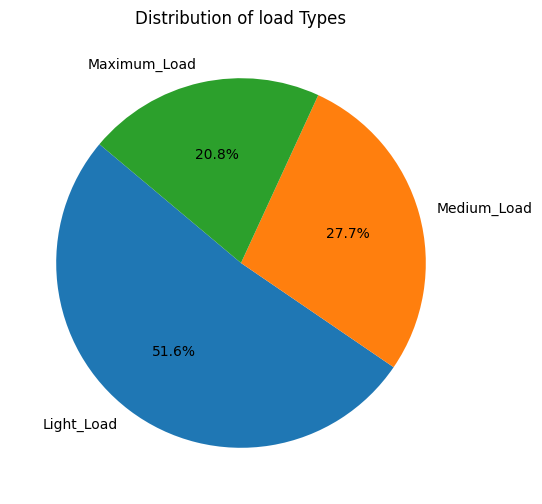

In [17]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Steel_industry_data.csv')  # Make sure the path is correct

# Display the distribution of a categorical column, e.g., "Machine_Type"
# Replace "Machine_Type" with the name of the column you'd like to visualize
machine_counts = data['Load_Type'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(machine_counts, labels=machine_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of load Types")
plt.show()



In [18]:
!pip install prophet


In [19]:
import pandas as pd

# Load the dataset
data = pd.read_csv('Steel_industry_data.csv')  # Adjust the file path as needed

# Ensure your date column is parsed correctly (dayfirst=True for day-first formats)
data['date'] = pd.to_datetime(data['date'], dayfirst=True)  # Adjust the 'date' column as needed

# Keep only Date and Usage_kWh columns, adjust column names based on your dataset
data = data[['date', 'Usage_kWh']]

# Rename columns to fit Prophet requirements: 'ds' for date and 'y' for target variable
data.columns = ['ds', 'y']

# Display the first few rows to verify
print(data.head())

                   ds     y
0 2018-01-01 00:15:00  3.17
1 2018-01-01 00:30:00  4.00
2 2018-01-01 00:45:00  3.24
3 2018-01-01 01:00:00  3.31
4 2018-01-01 01:15:00  3.82


In [20]:
from prophet import Prophet

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, daily_seasonality=False)
model.fit(data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpp5i9kn_g/vconxirp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp5i9kn_g/8e6zix46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92952', 'data', 'file=/tmp/tmpp5i9kn_g/vconxirp.json', 'init=/tmp/tmpp5i9kn_g/8e6zix46.json', 'output', 'file=/tmp/tmpp5i9kn_g/prophet_modelxwxomwxg/prophet_model-20241031182024.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:20:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:20:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [21]:
# Define the period for future prediction (365 days for one year)
future = model.make_future_dataframe(periods=365)

# Generate forecast
forecast = model.predict(future)


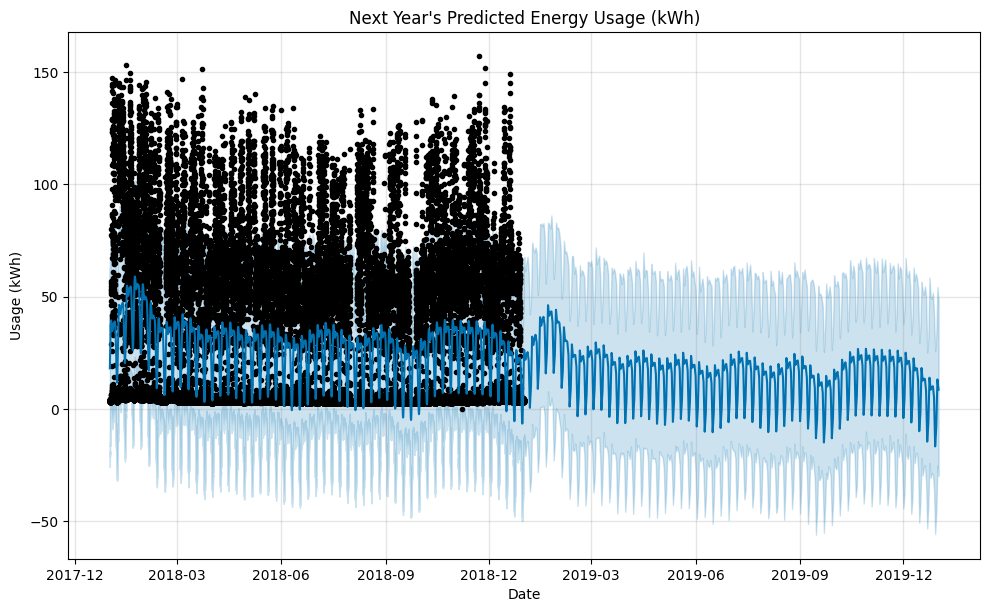

In [22]:
# Plot the forecast
model.plot(forecast)
plt.title("Next Year's Predicted Energy Usage (kWh)")
plt.xlabel("Date")
plt.ylabel("Usage (kWh)")
plt.show()


In [23]:
# Filter predictions for the next year only
next_year_forecast = forecast[forecast['ds'] > data['ds'].max()]

# Calculate average predicted usage for the next year
average_usage_next_year = next_year_forecast['yhat'].mean()
print("Average Predicted Usage for Next Year (kWh):", average_usage_next_year)


Average Predicted Usage for Next Year (kWh): 14.832277255089938


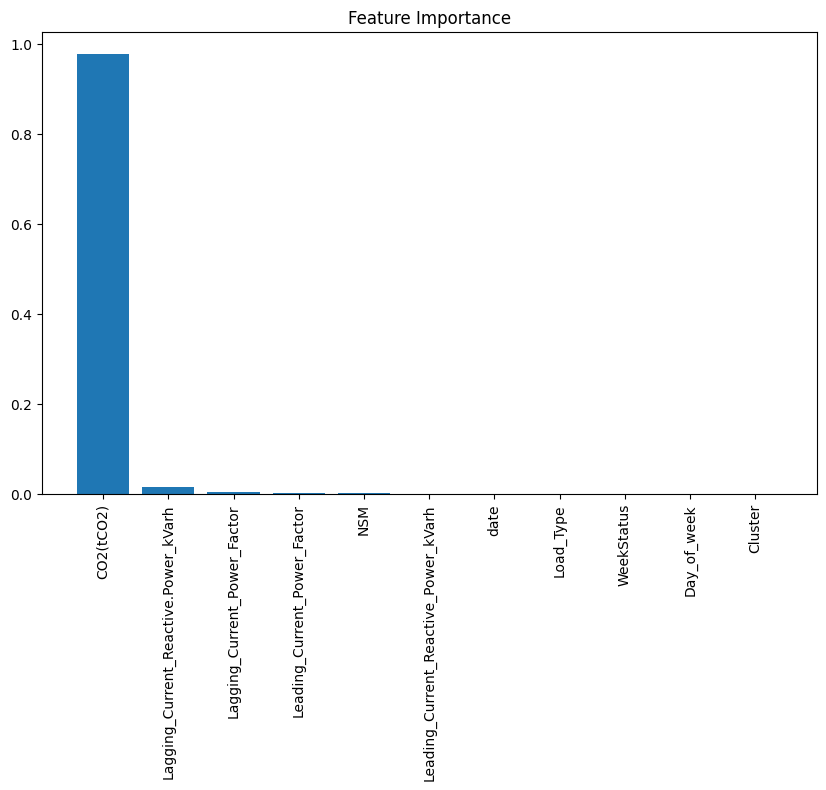

In [24]:
# Plot feature importance for the Random Forest Regressor
feature_importances = regressor.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_regression.shape[1]), feature_importances[sorted_indices], align="center")
plt.xticks(range(X_regression.shape[1]), X_regression.columns[sorted_indices], rotation=90)
plt.show()


In [25]:
# Save the trained regression model
joblib.dump(regressor, 'optimized_energy_consumption_model.pkl')
print("Model saved as 'optimized_energy_consumption_model.pkl'")


Model saved as 'optimized_energy_consumption_model.pkl'
